Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

Data loading and Preprocessing

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Loading dataset
df = pd.read_csv('/content/drive/MyDrive/Accommodation_Reviews.csv')

# Drop unnecessary columns
df = df[['Hotel_Name', 'Positive_Review', 'Negative_Review', 'Reviewer_Score']]

# Combine positive and negative reviews into a single column
df['Combined_Review'] = df['Positive_Review'].fillna('') + ' ' + df['Negative_Review'].fillna('')

# Preprocess using NLTK and NumPy
stop_words = set(stopwords.words('english'))

# Tokenize and remove stop words
df['Combined_Review'] = df['Combined_Review'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data Visualization

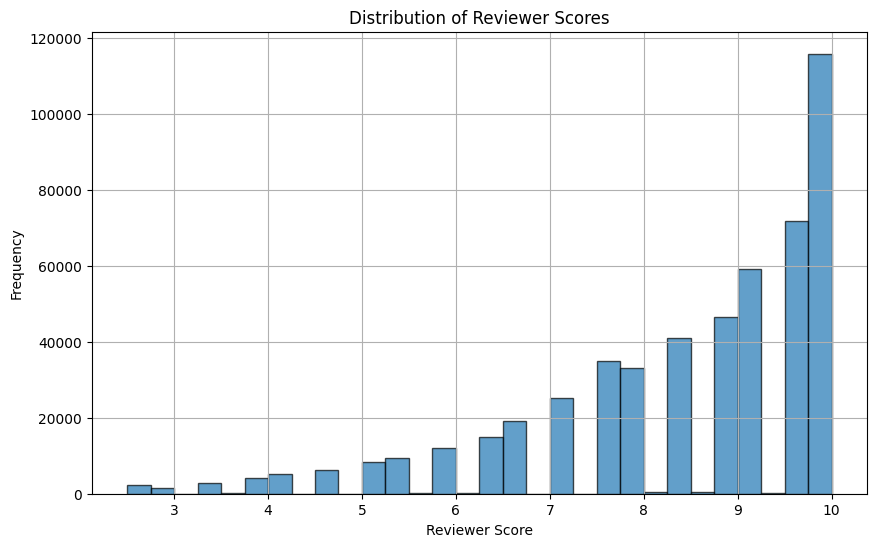

In [3]:
#visualize the distribution of reviewer scores
plt.figure(figsize=(10, 6))
df['Reviewer_Score'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Reviewer Scores')
plt.xlabel('Reviewer Score')
plt.ylabel('Frequency')
plt.show()

Model Development & Evaluation

In [4]:

# Creating a TF-IDF matrix for the combined reviews using NumPy
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Combined_Review'])

# Using k-Nearest Neighbors to find similar hotels
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(tfidf_matrix)


#Function to get personalized recommendations
def get_recommendations(hotel_name):
    hotel_index = df[df['Hotel_Name'] == hotel_name].index[0]
    query_vector = tfidf_matrix[hotel_index]
    _, indices = knn_model.kneighbors(query_vector)

    # Exclude the queried hotel itself
    similar_hotels = df.iloc[indices[0][1:]]

    return similar_hotels[['Hotel_Name', 'Reviewer_Score']]

#-Evaluating the model
# For simplicity, let's use a hypothetical query and evaluate the recommendations
query_hotel = 'Hotel Arena'
recommendations = get_recommendations(query_hotel)

# Display recommendations
print(f"Recommendations for {query_hotel}:")
print(recommendations)

#let's calculate the mean squared error between actual and predicted scores
predicted_scores = []
for hotel_name in df['Hotel_Name'].unique():
    recommendations = get_recommendations(hotel_name)
    actual_score = df[df['Hotel_Name'] == hotel_name]['Reviewer_Score'].values[0]
    predicted_score = recommendations['Reviewer_Score'].mean()
    predicted_scores.append(predicted_score)

mse = mean_squared_error(df.groupby('Hotel_Name')['Reviewer_Score'].mean(), np.array(predicted_scores))
print(f"Mean Squared Error: {mse}")


Recommendations for Hotel Arena:
                            Hotel_Name  Reviewer_Score
90106         Hotel Indigo Paris Opera             7.9
315276                    Melia Vienna            10.0
287115                   Hotel Alimara             6.7
408691  Best Western Plus Hotel Galles            10.0
Mean Squared Error: 1.3891743038467588
